# XRR Oscillation analysis

## Introduction

Bi-layer XRR oscillations are given by
$$ \sim \cos\left( l \sqrt{q^2-q_c^2}\right),$$
where $l$ is the layer surface distance and $q_c$ is the momentum transfer corresponding to the critical angle. With $x$ defined as
$$ x = \frac{1}{2\pi}\sqrt{q^2-q_c^2}, $$
we can find $l$ as the singular peak in the the fourier transform
$$\int \cos\left(2\pi l x\right)\, e^{-i2\pi l' x}\;dx = \frac{1}{2}\delta\left( l'-l\right),\quad \text{for }\; l'>0.$$

This notebook provides an interactive GUI for oscillation analaysis per the above. The screenshot below shows an example result (layer thickness of 39 nm).

<center>
<div>
<img src="XRR_osc.png" width="600"/>
</div>
</center>

### Bibliography

K. Sakurai and A. Iida, "Layer thickness determination of thin films by grazing incidence X-ray experiments using interference effect", [Advances in X-ray Analysis **35**(B), 813-818 (1991)](https://www.cambridge.org/core/journals/advances-in-x-ray-analysis/article/abs/layer-thickness-determination-of-thin-films-by-grazing-incidence-xray-experiments-using-interference-effect/B481EF87930950A7AF95AB4F35F00112)

O. Duran, "Characterization of multilayered materials for optoelectronic components by high-resolution X-ray diffractometry and reflectometry: contribution of numerical treatments", [Thin solid films **450**(1), 51-59 (2004)](https://doi.org/10.1016/j.tsf.2003.10.052)

M. Lammel et al., "Fast Fourier transform and multi-Gaussian fitting of XRR data to determine the thickness of ALD grown thin films within the initial growth regime", [Applied Physics Letters **117**(21), 213106 (2020)](https://pubs.aip.org/aip/apl/article-pdf/doi/10.1063/5.0024991/14542525/213106_1_online.pdf)

## Preamble

In [19]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import Layout
import ipywidgets as widgets

from scipy.fft import fft, fftshift, fftfreq
from scipy.interpolate import interp1d
from scipy.signal import butter
from scipy.signal import sosfilt
from scipy.optimize import curve_fit

In [20]:
#Style definitions
th_c_style = {'ls':':','c':'red'}
R_style = {'c':'k'}
guess_style = {'ls':':','c':'k','alpha':0.75}
fit_style = {'ls':'--','c':'k','alpha':0.5}

th_xlabel = '$\\theta\quad[\mathrm{deg.}]$'
R_ylabel = '$R\quad[\mathrm{arb.}]$'

th_c_leglabel = 'Critical angle $\\theta_c$'
R_leglabel = 'XRR data'

subplots_kwargs = {'constrained_layout':True}

## Load data (replace with your own)

In [21]:
data=np.loadtxt('example_data.txt')[:-80]

wl = 0.154           # Wavelength
unit = 'nm'          # Unit for wavelength

th = data[:,0]/2     # Incidence angle θ in degrees (2θ data needs to be divided by 2)
R = data[:,1]        # Reflectivity data

del data

## Preliminary processing

We first find an estimate of $\theta_c$ , do the transform $\theta\to x$ (explained above), and demonstrate some filtering.

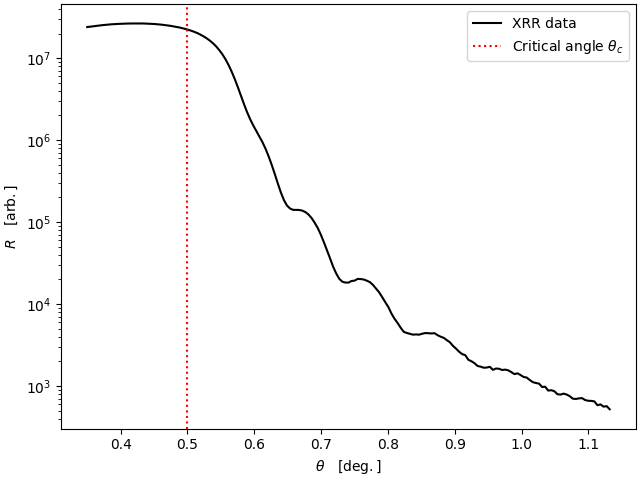

In [22]:
fig0,ax0 = plt.subplots(**subplots_kwargs)

ax0.plot(th,R,label=R_leglabel,**R_style)

# Estimate critical angle from the plot, or use literature value
th_c = 0.5 #Critical angle (theta), deg

ax0.axvline(th_c,**th_c_style, label=th_c_leglabel)
ax0.set(yscale='log', ylabel=R_ylabel, xlabel=th_xlabel)

ax0.legend()

In [23]:
# Convert θ to x

#Sakurai version, using small angle approximation to compute q
def th_to_x(theta,th_c):
    return 2*np.sqrt((theta*np.pi/180)**2-(th_c*np.pi/180)**2)/wl

# Durand version, slower but practically identical. Use Sakurai for faster performance, and Durand for high angles.
# def th_to_x(theta,th_c):
#     return 2*np.sqrt(np.sin((theta*np.pi/180))**2-np.sin(th_c*np.pi/180)**2)/wl
# resample_flag = True

x = th_to_x(th,th_c)

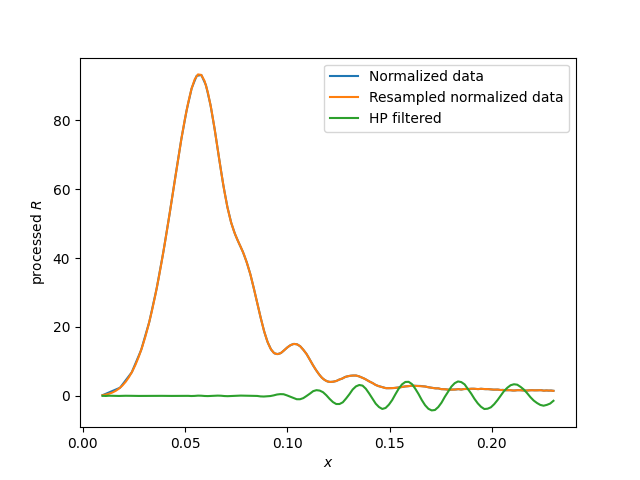

In [24]:
# intensity goes roughly as 1/x^4. Normalize by multiplying by x^4.
R_normed = np.power(x,4)*R

x_min=np.nanargmin(x)
x_max=np.nanargmax(x)

#We need a constant sampling rate in x.
x_uniform = np.linspace(x[x_min],x[x_max],x_max-x_min+1)
# Interpolate to uniform sampling
interp = interp1d(x[x_min:], R_normed[x_min:], kind='cubic')
R_uniform = interp(x_uniform)
    
fs = x_uniform.size/(x_uniform[-1]-x_uniform[0]) # sample rate

# To get rid of remaining low frequency noise, pass the signal through a hp filter.
filter_order = 35
filter_cutoff = 30
sos = butter(filter_order, filter_cutoff, 'hp', fs=fs, output='sos')
R_filtered =  sosfilt(sos, R_uniform)

fig1, ax1 = plt.subplots()

ax1.set(yscale='linear', xlabel='$x$',ylabel='processed $R$')

ax1.plot(x, R_normed, label = 'Normalized data')
ax1.plot(x_uniform, R_uniform, label = 'Resampled normalized data')
ax1.plot(x_uniform, R_filtered , label='HP filtered')
ax1.legend()

The oscilliation frequency in 'hp filtered' can now be found with FFT. We will fine-tune the filter and critical angle in the coming steps.

## Interactive FFT and oscillation analysis 

In [26]:
#Functions to update plot with slider actions. Execute this box without modifications

def update_fig2_cutoff(change):
    global filter_cutoff
    global sos
    global R_filtered
    global FT_filtered
    
    filter_cutoff = change.new
    
    sos = butter(filter_order, filter_cutoff, 'hp', fs=fs, output='sos')
    R_filtered =  sosfilt(sos, R_uniform)
    FT_filtered = np.abs(fftshift(fft(R_filtered, n=n)))[n//2:]
    filt_plot[0].set_data(d,FT_filtered/FT_filtered.max())
    
def update_fig2_order(change):
    global filter_order
    global R_filtered
    global FT_filtered
    global sos
    
    filter_order = change.new
    
    sos = butter(filter_order, filter_cutoff, 'hp', fs=fs, output='sos')
    R_filtered =  sosfilt(sos, R_uniform)
    FT_filtered = np.abs(fftshift(fft(R_filtered, n=n)))[n//2:]
    filt_plot[0].set_data(d,FT_filtered/FT_filtered.max())

def update_fig2_th_c(change):
    
    global th_c
    global x_uniform
    global R_normed
    global interp
    global R_uniform
    global fs
    global d
    global R_filtered
    global FT_filtered
    global FT_unfiltered
    
    th_c = change.new           # Critical angle (theta deg.)

    x = th_to_x(th,th_c)
    
    R_normed=np.power(x,4)*R      # Normalize by multiplying by x^4.

    x_min=np.nanargmin(x)
    x_max=np.nanargmax(x)
    
    #We need a constant sampling rate in x.
    x_uniform = np.linspace(x[x_min],x[x_max],x_max-x_min+1)
    # Interpolate to uniform sampling
    interp = interp1d(x[x_min:], R_normed[x_min:], kind='cubic')
    R_uniform = interp(x_uniform)
    
    fs = x_uniform.size/(x_uniform[-1]-x_uniform[0]) # sample rate
    d = fftshift(fftfreq(n,x_uniform[1]-x_uniform[0]))[n//2:]
    
    R_filtered =  sosfilt(sos, R_uniform)
    
    FT_unfiltered = np.abs(fftshift(fft(R_uniform, n=n)))[n//2:]
    FT_filtered = np.abs(fftshift(fft(R_filtered, n=n)))[n//2:]
    
    filt_plot[0].set_data(d, FT_filtered/FT_filtered.max())
    unfilt_plot[0].set_data(d, FT_unfiltered/FT_unfiltered.max())
    th_c_line.set_xdata([th_c,th_c])

def update_fig2_n(change):
    global n
    global FT_filtered
    global FT_unfiltered
    global d
    
    n = change.new
    
    FT_unfiltered = np.abs(fftshift(fft(R_uniform, n=n)))[n//2:]
    FT_filtered = np.abs(fftshift(fft(R_filtered, n=n)))[n//2:]
    d = fftshift(fftfreq(n,x_uniform[1]-x_uniform[0]))[n//2:]
    
    filt_plot[0].set_data(d, FT_filtered/FT_filtered.max())
    unfilt_plot[0].set_data(d, FT_unfiltered/FT_unfiltered.max())
    
def update_guess(change):
    global guess
    global guess_line
    
    guess = change.new
    guess_line.set_xdata([guess,guess])
    
def gauss(x,A,s,mu,b):
    return A*np.exp(-((x-mu)/s)**2)+b

def update_fit(b):
    global fit_curve
    global fit
    
    range_ind = (d>guess-50) & (d<guess+50)
    fit_d = d[range_ind]
    fit_inds = np.arange(d.shape[0])[range_ind]
    
    fit = curve_fit(gauss,fit_d,FT_filtered[fit_inds]/FT_filtered.max(), p0=[1,10,guess,0], bounds=([0,0,0,0],[1,np.inf,d[-1],np.inf]))
    
    plot_x=np.linspace(fit_d[0],fit_d[-1],500)
    fit_curve[0].set_data(plot_x,gauss(plot_x,*fit[0]))
    
    fit_output.clear_output()
    with fit_output:
        print('Fit results')
        print('μ: ',fit[0][2], unit)
        print('σ: ', fit[0][1], unit)

slider_length='500px'

Below is the interactive content of this notebook. Use it to perfrom the oscillation analysis.

FloatSlider(value=0.5, description='Critical angle', layout=Layout(width='500px'), max=1.1320000000000001, min…

IntSlider(value=24, description='Filter cutoff', layout=Layout(width='500px'), max=308, min=1)

IntSlider(value=26, description='Filter order', layout=Layout(width='500px'))

IntSlider(value=300, description='Output bins', layout=Layout(width='500px'), max=1000, min=10)

FloatSlider(value=154.24102880058865, description='Fit μ guess ', layout=Layout(width='500px'), max=308.482057…

Button(description='Fit Gaussian', style=ButtonStyle())

Output()

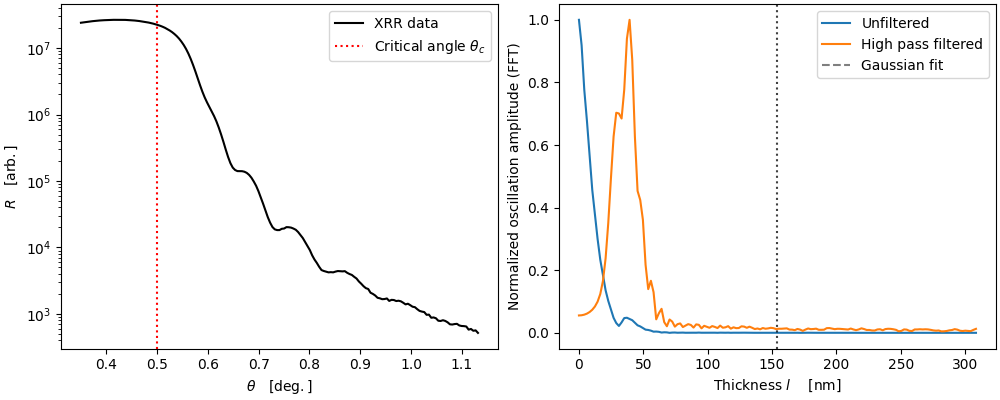

In [28]:
# Initialize interactive plot
fig2, ax2 = plt.subplots(1,2,figsize=(10,4),constrained_layout=True)

plt.ion()

n = 300 #number of points in fft output

# Curves and lines
FT_unfiltered = np.abs(fftshift(fft(R_uniform, n=n)))[n//2:]
FT_filtered = np.abs(fftshift(fft(R_filtered, n=n)))[n//2:]
d =fftshift(fftfreq(n,x_uniform[1]-x_uniform[0]))[n//2:]
guess = np.median(d) #initial guess for Gaussian fit

R_plot = ax2[0].plot(th,R,label=R_leglabel, **R_style)
th_c_line = ax2[0].axvline(th_c,**th_c_style,label=th_c_leglabel)
            
unfilt_plot = ax2[1].plot(d,FT_unfiltered/FT_unfiltered.max(), label='Unfiltered')
filt_plot = ax2[1].plot(d,FT_filtered/FT_filtered.max(), label='High pass filtered')

fit_curve = ax2[1].plot(0,0,label='Gaussian fit',**fit_style)

guess_line = ax2[1].axvline(x=guess, **guess_style)

# Plot settings
ax2[0].legend()
ax2[1].legend()
ax2[0].set(yscale='log',ylabel=R_ylabel,xlabel=th_xlabel)
ax2[1].set(ylabel='Normalized oscillation amplitude (FFT)', xlabel='Thickness $l$ $\quad[\mathrm{nm}]$')

# Initialize sliders and buttons 
cutoff_slider = widgets.IntSlider(min=1,max=d.max(),step=1,value=filter_cutoff, description='Filter cutoff', layout=Layout(width=slider_length))
cutoff_slider.observe(update_fig2_cutoff, names='value')

order_slider = widgets.IntSlider(min=0,max=100,step=1,value=filter_order , description='Filter order', layout=Layout(width=slider_length))
order_slider.observe(update_fig2_order, names='value')

th_c_slider = widgets.FloatSlider(min=th[0],max=th[-1],step=1e-3,value=th_c, readout_format='.3f', description='Critical angle', layout=Layout(width=slider_length))
th_c_slider.observe(update_fig2_th_c, names='value')

n_slider = widgets.IntSlider(min=10,max=1000,step=1,value=n , description='Output bins', layout=Layout(width=slider_length))
n_slider.observe(update_fig2_n, names='value')

guess_slider = widgets.FloatSlider(min=0,max=d[-1],step=1e-3,value=guess, readout_format='.3f', description='Fit μ guess ', layout=Layout(width=slider_length))
guess_slider.observe(update_guess, names='value')

fit_button = widgets.Button(description='Fit Gaussian')
fit_output = widgets.Output()
fit_button.on_click(update_fit)

display(th_c_slider, cutoff_slider, order_slider, n_slider, guess_slider, fit_button, fit_output)


The fit output can by accesed like this:

In [18]:
param_names = ['Amplitude','σ ','μ ','Baseline ']
fit_result = dict(zip(param_names,fit[0]))
cov_mat = fit[1]

for key,v in fit_result.items():
    print(f'{key:15}{v}')
print('\nCovariance:', )
print(cov_mat)

Amplitude      0.9026058286212526
σ              8.561436070665733
μ              39.15888526077385
Baseline       0.0579504460731576

Covariance:
[[ 4.93208377e-04 -2.36948066e-03  2.01206264e-10 -4.18953003e-05]
 [-2.36948066e-03  6.62726610e-02 -1.88984026e-09 -7.94774254e-04]
 [ 2.01206264e-10 -1.88984026e-09  2.78057160e-02 -1.61573180e-13]
 [-4.18953003e-05 -7.94774254e-04 -1.61573180e-13  5.92489017e-05]]
